# CONVOLUTION  AUTOENCODERS

In [1]:
import tensorflow as tf
from tensorflow.keras.models import save_model
import tensorflow.keras.layers as L
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
#loading images
path='D:/lungcancer/lungimage/test'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
train_batches=ImageDataGenerator().flow_from_directory(path,target_size=(224,224),classes=['malignant','benign'],batch_size=10)
imgs,labels=next(train_batches)

Found 10 images belonging to 2 classes.


In [5]:
IMG_SHAPE=imgs.shape[1:]

In [6]:
imgs = imgs.astype('float32') / 255.0 - 0.5

In [7]:
print("img.max:",imgs.max())
print("img.min:",imgs.min())

img.max: 0.5
img.min: -0.5


In [8]:
x_train,x_test=train_test_split(imgs,test_size=0.2, random_state=42)

In [9]:
len(x_train)

8

In [10]:
len(x_test)

2

In [11]:
x_train.shape

(8, 224, 224, 3)

In [12]:
x_test.shape

(2, 224, 224, 3)

In [14]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

images shape: (10, 224, 224, 3)
attr shape: (10, 2)


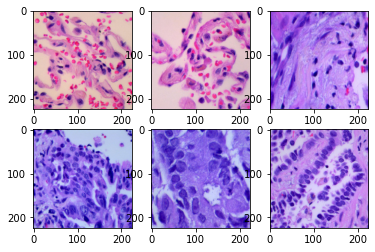

In [16]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(imgs[i])

print("images shape:", imgs.shape)
print("attr shape:", labels.shape)

In [13]:
IMG_SHAPE

(224, 224, 3)

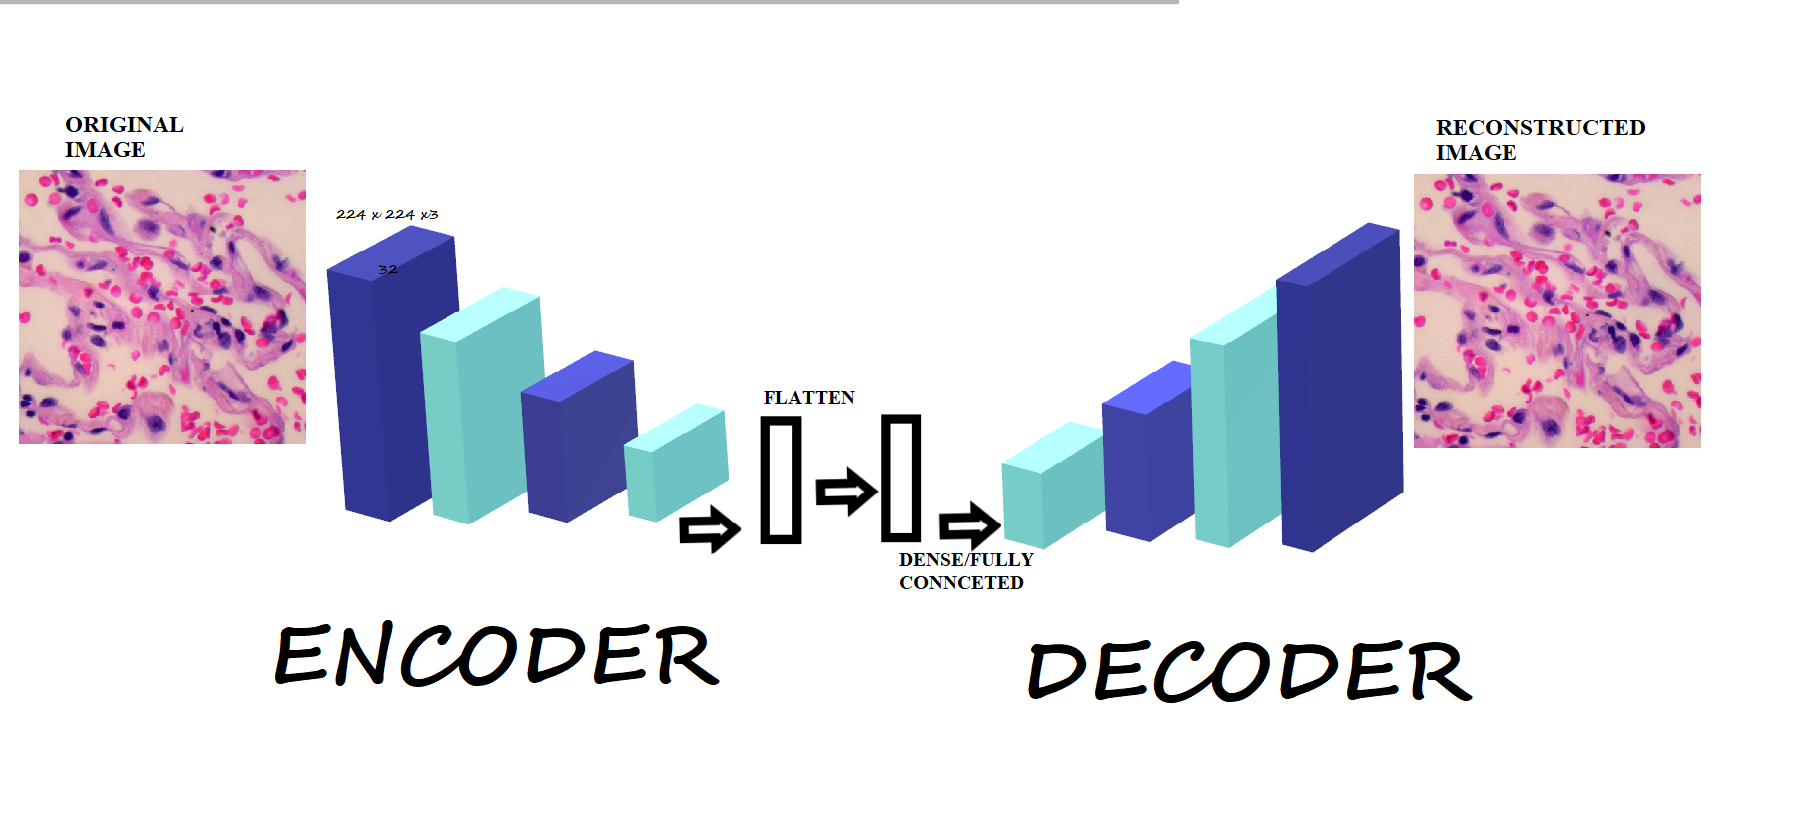

In [17]:
def build_deep_autoencoder(img_shape, code_size):
    
    H,W,C = img_shape
    
    # encoder
    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(filters=32,input_shape=(224,224,3), kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(14*14*256,))
    decoder.add(L.Reshape((14,14, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


In [18]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    print("encoder",encoder.output_shape[1:])
    print("decoder",decoder.output_shape[1:])
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
encoder (1,)
decoder (224, 224, 3)
Testing code size 8
encoder (8,)
decoder (224, 224, 3)
Testing code size 32
encoder (32,)
decoder (224, 224, 3)
Testing code size 128
encoder (128,)
decoder (224, 224, 3)
Testing code size 512
encoder (512,)
decoder (224, 224, 3)
All tests passed!


In [19]:
tf.keras.backend.clear_session()

In [20]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=1000)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [21]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

In [22]:
#input given bu encoder to decoder
code

<tf.Tensor 'sequential/Identity:0' shape=(None, 1000) dtype=float32>

In [23]:
inp

<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>

In [24]:
reconstruction

<tf.Tensor 'sequential_1/Identity:0' shape=(None, 224, 224, 3) dtype=float32>

In [25]:
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse',metrics=['accuracy'])

In [26]:
autoencoder.fit(x=x_train, y=x_train, epochs=600,
                validation_data=[x_test, x_test])

Train on 8 samples, validate on 2 samples
Epoch 1/600
8/8 [==============================] - 11s 1s/sample - loss: 0.0759 - accuracy: 0.3216 - val_loss: 0.0787 - val_accuracy: 0.3906
Epoch 2/600
8/8 [==============================] - 0s 22ms/sample - loss: 0.0748 - accuracy: 0.4045 - val_loss: 0.0691 - val_accuracy: 0.4181
Epoch 3/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0651 - accuracy: 0.4657 - val_loss: 0.0708 - val_accuracy: 0.4023
Epoch 4/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0650 - accuracy: 0.5294 - val_loss: 0.0575 - val_accuracy: 0.3831
Epoch 5/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0525 - accuracy: 0.5810 - val_loss: 0.0568 - val_accuracy: 0.3438
Epoch 6/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0513 - accuracy: 0.6425 - val_loss: 0.0523 - val_accuracy: 0.3189
Epoch 7/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0439 - accuracy: 0.6990 - val_l

Epoch 59/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0042 - accuracy: 0.9854 - val_loss: 0.0365 - val_accuracy: 0.5694
Epoch 60/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0041 - accuracy: 0.9860 - val_loss: 0.0367 - val_accuracy: 0.5848
Epoch 61/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0040 - accuracy: 0.9869 - val_loss: 0.0369 - val_accuracy: 0.5918
Epoch 62/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0039 - accuracy: 0.9877 - val_loss: 0.0369 - val_accuracy: 0.5872
Epoch 63/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0039 - accuracy: 0.9879 - val_loss: 0.0368 - val_accuracy: 0.5836
Epoch 64/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0038 - accuracy: 0.9880 - val_loss: 0.0368 - val_accuracy: 0.5844
Epoch 65/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0037 - accuracy: 0.9882 - val_loss: 0.0367 - val_accuracy: 0.5866

Epoch 117/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0020 - accuracy: 0.9940 - val_loss: 0.0367 - val_accuracy: 0.6425
Epoch 118/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0020 - accuracy: 0.9940 - val_loss: 0.0367 - val_accuracy: 0.6431
Epoch 119/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0020 - accuracy: 0.9940 - val_loss: 0.0368 - val_accuracy: 0.6438
Epoch 120/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0020 - accuracy: 0.9941 - val_loss: 0.0368 - val_accuracy: 0.6442
Epoch 121/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0020 - accuracy: 0.9941 - val_loss: 0.0368 - val_accuracy: 0.6436
Epoch 122/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0019 - accuracy: 0.9941 - val_loss: 0.0368 - val_accuracy: 0.6430
Epoch 123/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0019 - accuracy: 0.9942 - val_loss: 0.0368 - val_accuracy:

Epoch 174/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0015 - accuracy: 0.9952 - val_loss: 0.0369 - val_accuracy: 0.6467
Epoch 175/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0015 - accuracy: 0.9953 - val_loss: 0.0369 - val_accuracy: 0.6467
Epoch 176/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0015 - accuracy: 0.9953 - val_loss: 0.0369 - val_accuracy: 0.6467
Epoch 177/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0014 - accuracy: 0.9953 - val_loss: 0.0369 - val_accuracy: 0.6467
Epoch 178/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0014 - accuracy: 0.9953 - val_loss: 0.0369 - val_accuracy: 0.6467
Epoch 179/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0014 - accuracy: 0.9953 - val_loss: 0.0369 - val_accuracy: 0.6466
Epoch 180/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0014 - accuracy: 0.9953 - val_loss: 0.0369 - val_accuracy:

Epoch 231/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0370 - val_accuracy: 0.6462
Epoch 232/600
8/8 [==============================] - 0s 21ms/sample - loss: 0.0012 - accuracy: 0.9958 - val_loss: 0.0370 - val_accuracy: 0.6462
Epoch 233/600
8/8 [==============================] - 0s 23ms/sample - loss: 0.0012 - accuracy: 0.9959 - val_loss: 0.0370 - val_accuracy: 0.6462
Epoch 234/600
8/8 [==============================] - 0s 24ms/sample - loss: 0.0012 - accuracy: 0.9959 - val_loss: 0.0370 - val_accuracy: 0.6463
Epoch 235/600
8/8 [==============================] - 0s 23ms/sample - loss: 0.0012 - accuracy: 0.9959 - val_loss: 0.0370 - val_accuracy: 0.6462
Epoch 236/600
8/8 [==============================] - 0s 23ms/sample - loss: 0.0012 - accuracy: 0.9959 - val_loss: 0.0370 - val_accuracy: 0.6461
Epoch 237/600
8/8 [==============================] - 0s 22ms/sample - loss: 0.0012 - accuracy: 0.9959 - val_loss: 0.0370 - val_accuracy:

Epoch 288/600
8/8 [==============================] - 0s 20ms/sample - loss: 0.0010 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 0.6455
Epoch 289/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.9958e-04 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 0.6455
Epoch 290/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.9700e-04 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 0.6455
Epoch 291/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.9444e-04 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 0.6455
Epoch 292/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.9189e-04 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 0.6456
Epoch 293/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.8936e-04 - accuracy: 0.9962 - val_loss: 0.0370 - val_accuracy: 0.6456
Epoch 294/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.8685e-04 - accuracy: 0.9962 - val_loss

Epoch 344/600
8/8 [==============================] - 0s 21ms/sample - loss: 8.8131e-04 - accuracy: 0.9965 - val_loss: 0.0371 - val_accuracy: 0.6461
Epoch 345/600
8/8 [==============================] - 0s 20ms/sample - loss: 8.9712e-04 - accuracy: 0.9965 - val_loss: 0.0369 - val_accuracy: 0.6250
Epoch 346/600
8/8 [==============================] - 0s 21ms/sample - loss: 9.1065e-04 - accuracy: 0.9964 - val_loss: 0.0371 - val_accuracy: 0.6470
Epoch 347/600
8/8 [==============================] - 0s 20ms/sample - loss: 8.8009e-04 - accuracy: 0.9965 - val_loss: 0.0371 - val_accuracy: 0.6455
Epoch 348/600
8/8 [==============================] - 0s 22ms/sample - loss: 8.7943e-04 - accuracy: 0.9965 - val_loss: 0.0369 - val_accuracy: 0.6280
Epoch 349/600
8/8 [==============================] - 0s 20ms/sample - loss: 8.9510e-04 - accuracy: 0.9965 - val_loss: 0.0371 - val_accuracy: 0.6451
Epoch 350/600
8/8 [==============================] - 0s 20ms/sample - loss: 8.7614e-04 - accuracy: 0.9965 - val_

Epoch 400/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.8671e-04 - accuracy: 0.9967 - val_loss: 0.0369 - val_accuracy: 0.6334
Epoch 401/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.8537e-04 - accuracy: 0.9967 - val_loss: 0.0369 - val_accuracy: 0.6321
Epoch 402/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.8390e-04 - accuracy: 0.9967 - val_loss: 0.0369 - val_accuracy: 0.6325
Epoch 403/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.8238e-04 - accuracy: 0.9967 - val_loss: 0.0369 - val_accuracy: 0.6329
Epoch 404/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.8101e-04 - accuracy: 0.9967 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 405/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.7961e-04 - accuracy: 0.9967 - val_loss: 0.0369 - val_accuracy: 0.6327
Epoch 406/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.7813e-04 - accuracy: 0.9967 - val_

Epoch 456/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.1426e-04 - accuracy: 0.9969 - val_loss: 0.0369 - val_accuracy: 0.6321
Epoch 457/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.1311e-04 - accuracy: 0.9969 - val_loss: 0.0369 - val_accuracy: 0.6322
Epoch 458/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.1196e-04 - accuracy: 0.9970 - val_loss: 0.0369 - val_accuracy: 0.6323
Epoch 459/600
8/8 [==============================] - 0s 21ms/sample - loss: 7.1081e-04 - accuracy: 0.9970 - val_loss: 0.0369 - val_accuracy: 0.6322
Epoch 460/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.0967e-04 - accuracy: 0.9970 - val_loss: 0.0369 - val_accuracy: 0.6323
Epoch 461/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.0853e-04 - accuracy: 0.9970 - val_loss: 0.0369 - val_accuracy: 0.6323
Epoch 462/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.0740e-04 - accuracy: 0.9970 - val_

Epoch 512/600
8/8 [==============================] - 0s 21ms/sample - loss: 6.5562e-04 - accuracy: 0.9973 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 513/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.5467e-04 - accuracy: 0.9973 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 514/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.5373e-04 - accuracy: 0.9973 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 515/600
8/8 [==============================] - 0s 21ms/sample - loss: 6.5279e-04 - accuracy: 0.9973 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 516/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.5185e-04 - accuracy: 0.9973 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 517/600
8/8 [==============================] - 0s 21ms/sample - loss: 6.5091e-04 - accuracy: 0.9973 - val_loss: 0.0369 - val_accuracy: 0.6320
Epoch 518/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.4998e-04 - accuracy: 0.9973 - val_

Epoch 568/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.0776e-04 - accuracy: 0.9974 - val_loss: 0.0369 - val_accuracy: 0.6311
Epoch 569/600
8/8 [==============================] - 0s 21ms/sample - loss: 6.0801e-04 - accuracy: 0.9974 - val_loss: 0.0369 - val_accuracy: 0.6352
Epoch 570/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.0962e-04 - accuracy: 0.9974 - val_loss: 0.0369 - val_accuracy: 0.6289
Epoch 571/600
8/8 [==============================] - 0s 21ms/sample - loss: 6.1433e-04 - accuracy: 0.9974 - val_loss: 0.0369 - val_accuracy: 0.6380
Epoch 572/600
8/8 [==============================] - 0s 20ms/sample - loss: 6.2654e-04 - accuracy: 0.9974 - val_loss: 0.0369 - val_accuracy: 0.6240
Epoch 573/600
8/8 [==============================] - 0s 21ms/sample - loss: 6.5542e-04 - accuracy: 0.9974 - val_loss: 0.0370 - val_accuracy: 0.6447
Epoch 574/600
8/8 [==============================] - 0s 20ms/sample - loss: 7.2501e-04 - accuracy: 0.9974 - val_

In [28]:
predictions.shape

(2, 224, 224, 3)

In [32]:
#plotting the training data which will be tested.
predictions1=autoencoder.predict(x_train)

In [42]:
results = autoencoder.evaluate(x_train,x_train)
print('loss, accuracy', results)

8/8 [==============================] - 0s 45ms/sample - loss: 5.8869e-04 - accuracy: 0.9975
loss, accuracy [0.000588688300922513, 0.9975262]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


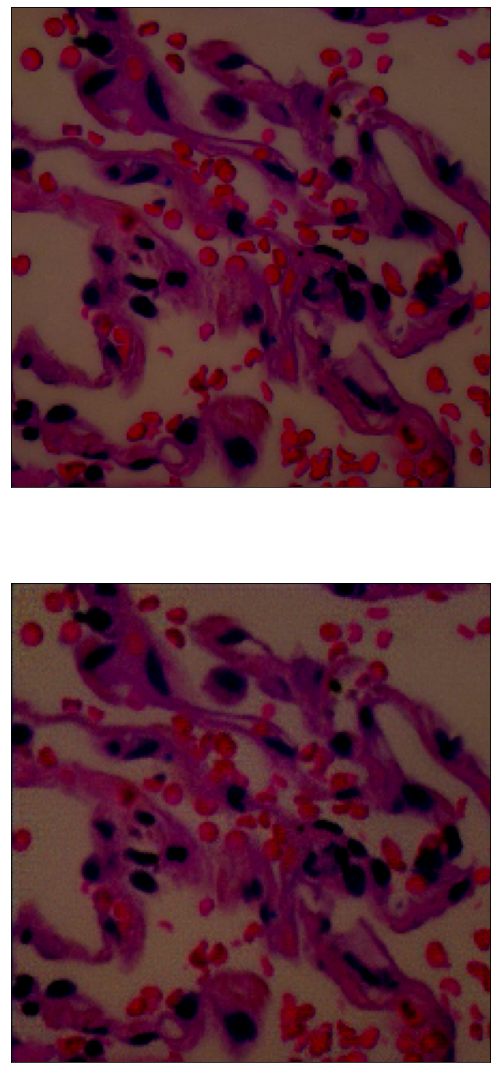

RECONSTRUCTED IMAGES ARE SHOWN


In [51]:
n = 1
plt.figure(figsize= (40,30))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(x_train[i+1])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions1[i+1])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()
print("RECONSTRUCTED IMAGES ARE SHOWN")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


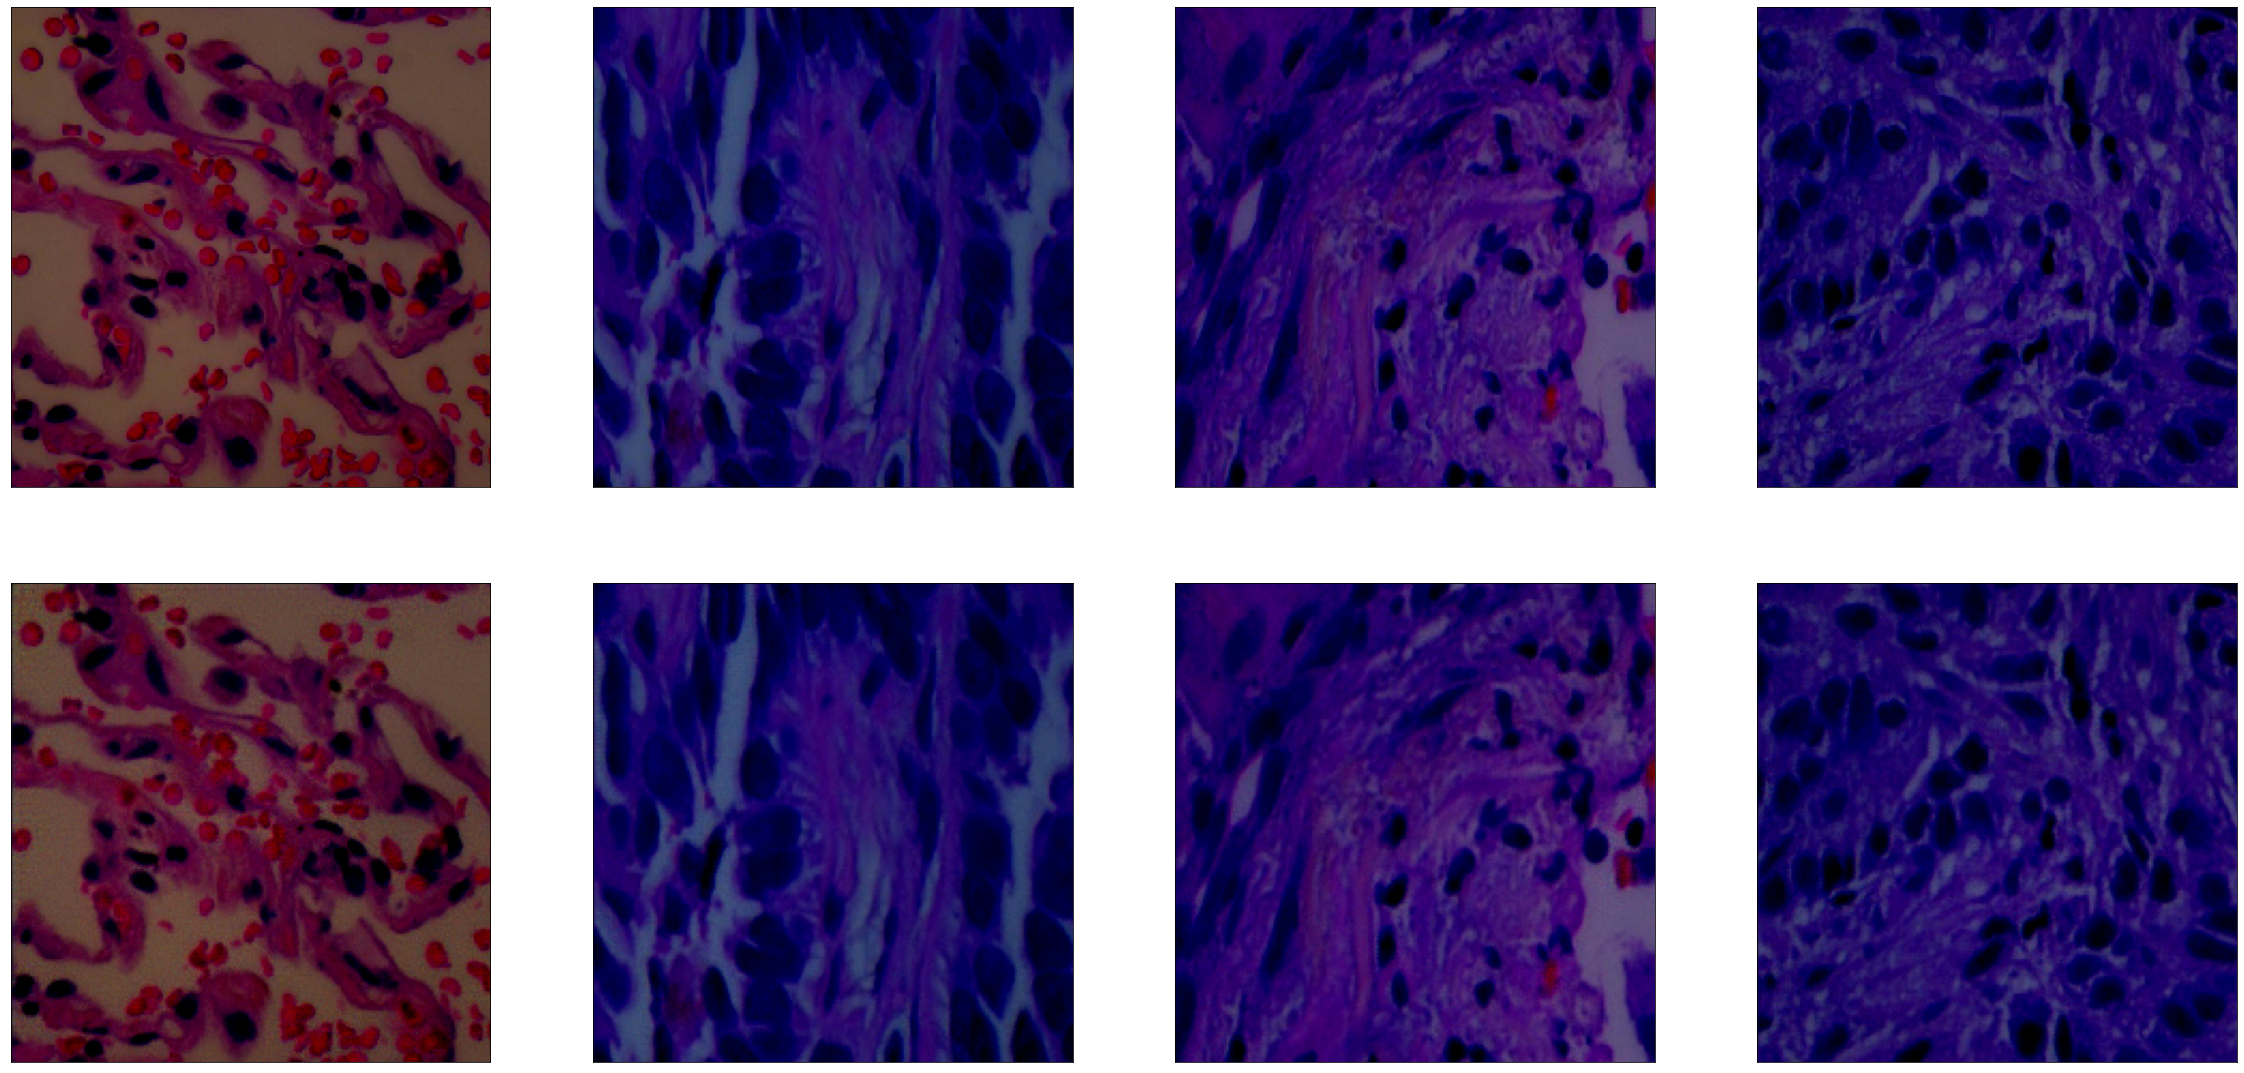

RECONSTRUCTED IMAGES ARE SHOWN


In [50]:
n = 4
plt.figure(figsize= (40,30))

for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(x_train[i+1])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  

  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions1[i+1])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


plt.show()
print("RECONSTRUCTED IMAGES ARE SHOWN")

In [34]:
# saving model
model_filename='autoencoder.{0:03d}.hdf5'
last_finished_epoch=None

In [35]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [45]:
len(predictions1)

8

In [37]:
def visualize(img,encoder,decoder):
    
    code = encoder.predict(img[None])[0] 
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

Convolutional autoencoder MSE of the Training images: [0.000588688300922513, 0.9975262]


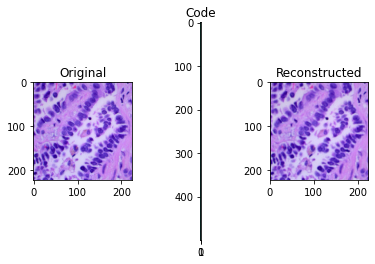

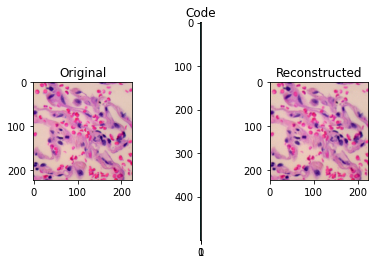

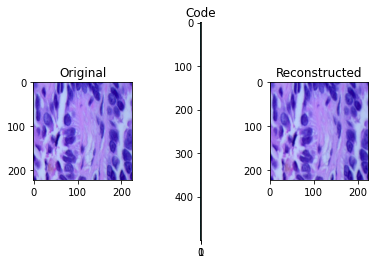

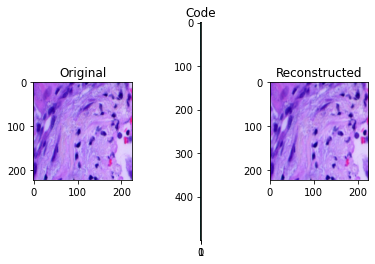

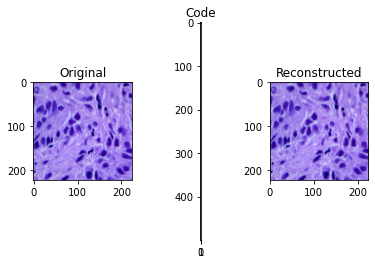

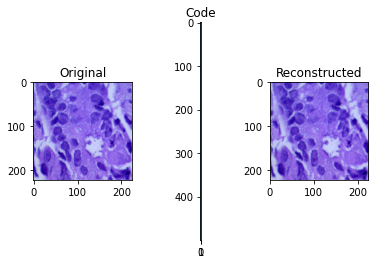

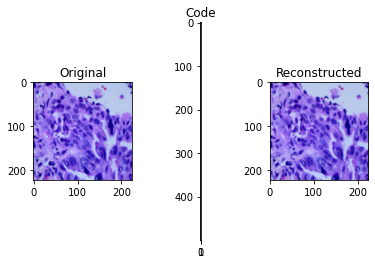

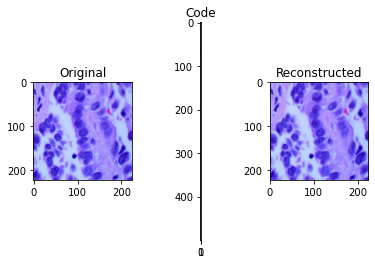

In [40]:
reconstruction_mse = autoencoder.evaluate(x_train, x_train, verbose=0)
print("Convolutional autoencoder MSE of the Training images:", reconstruction_mse)
for i in range(8):
    img = x_train[i]
    visualize(img,encoder,decoder)